In [1]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import pandas as pd
import os
from treys import Card
from termcolor import colored
from utils import eval_listof_games , debug_listof_games, save_results , load_results
import scipy

In [2]:
import skimage.io
import matplotlib.pyplot as plt
from skimage.segmentation import flood, flood_fill
from skimage import morphology
from skimage.morphology import closing, opening, disk, square
from skimage import filters
import cv2 as cv

In [106]:
from helper import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import all train data

In [4]:
path_data = 'data/train'
i = 0
file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
images = []

while os.path.exists(file):
    im = skimage.io.imread(file)
    images.append(im)
    i += 1
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")

Subsample to 2 images for now

In [5]:
images = [images[1], images[4], images[8], images[22]]

## Segment image

In [7]:
""" GLOBAL CONSTANTS (SCOTCH MARKERS) """
P1 = [0.5, 0.875]
P2 = [0.122, 0.749]
P3 = [0.135, 0.308]
P4 = [0.54, 0.107]
C1 = [0.932, 0.227]
C2 = [0.932, 0.381]
C3 = [0.932, 0.535]
C4 = [0.932, 0.673]
C5 = [0.924, 0.811]
MARKERS = np.array([P1, P2, P3, P4,
                          C1, C2, C3, C4, C5])
CARD_DIM = [0.165, 0.118]

""" Use global constants in functions """

def find_markers_idx(image):
    table_dim = image.shape[:2]
    return (MARKERS * table_dim).astype(int)

def find_player_search_area(image, marker):
    # adapt search area to table size
    row, col = image.shape[:2]
    R, C = int(row/6), int(col/6)
    x1, x2, y1, y2 = marker[0]-R, marker[0]+R, marker[1]-C, marker[1]+C
    # return a crop on the image
    x1, x2 = np.clip([x1, x2], 0, row)
    y1, y2 = np.clip([y1, y2], 0, col)
    search_area = image[x1:x2, y1:y2]
    return search_area

def find_common_search_area(image, markers):
    """ Works but a bit edgy, would be better to rely on something else """
    # isolate a 1rst big search area in bottom 3rd of the image
    row, col = image.shape[:2]
    C = int((CARD_DIM[1]*col))
    start, end = markers[0,1]-C, markers[-1,1]+C
    big_area = image[int(2/3*row):row, start:end]
    """ FINALLY WE DONT CUT THE IMAGE HERE"""
    return big_area
    
    
#     # refine using edge detector and contours filtering
#     edges = edge_detector([big_area])[0]
#     contours = contours_by_img([edges])[0]
#     contours = filter_contours_by_size([contours], 100, 3000)[0]
#     start = np.min([np.min(contour[0,:]) for contour in contours])
#     end = np.max([np.max(contour[0,:]) for contour in contours])

#     # rescale image and divide in 5
#     big_area = big_area[:,start:end]
#     w = int(big_area.shape[1]/5)
#     cards = [big_area[ : , w*i : w*(1+i) ] for i in range(5)]
#     return cards

In [119]:
test_image = images[0]

crop table and define markers on it

In [120]:
_, crop = cropping_routine(test_image)
markers = find_markers_idx(crop)
player_markers, common_markers = markers[:4], markers[4:]

isolate player areas

In [121]:
player_areas = []
for marker in player_markers:
    search_area = find_player_search_area(crop, marker)
    player_areas.append(search_area)

isolate common cards areas

In [122]:
common_areas = find_common_search_area(crop, common_markers)

(verify result)

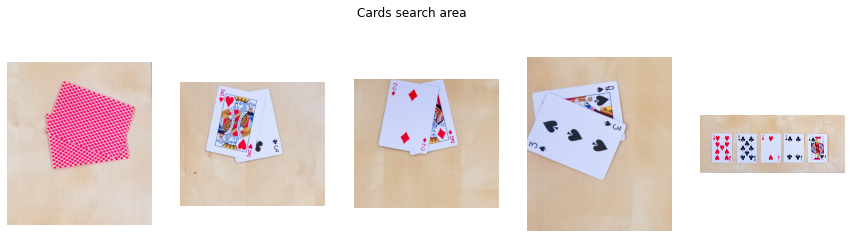

In [123]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize=(15,4))
for area, ax in zip(player_areas + [common_areas], axes.flatten()):
    #ax.scatter(603,587)
    #ax.scatter(826,545)
    ax.imshow(area)
    ax.axis('off')
fig.suptitle('Cards search area')
plt.show()

### contours from standard procedure

In [124]:
edges = edge_detector(player_areas)
contours = contours_by_img(edges)
filt_contours = filter_contours_by_size(contours, 69, 310) #value taken from setup_data notebook

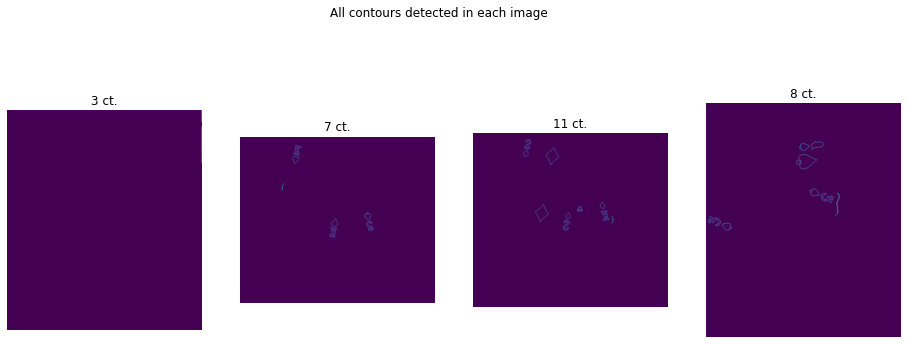

In [125]:
fig, axes = plt.subplots(ncols = 4, figsize=(16,15))
for ax, contours, image in zip(axes.flatten(), filt_contours, player_areas):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im)
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
fig.suptitle('All contours detected in each image', y = 0.7)
plt.show()

## Contours from card isolation procedure

In [126]:
imgs = player_areas+[common_areas]
#mod_areas = [skimage.filters.unsharp_mask((player_areas+common_areas)[i], radius = 0, channel_axis = 2) for i in range(9)]
#mod_areas = [skimage.color.rgb2gray(image) for image in imgs]
#mod_areas = [hist_eq(x) for x in imgs]
#mod_areas = [img[:,:,1] for img in imgs]
#mod_areas = [skimage.color.rgb2hsv(image) for image in mod_areas]
#mod_areas = [skimage.segmentation.flood_fill(x, (0,0), 0, tolerance=0.3) for x in mod_areas]

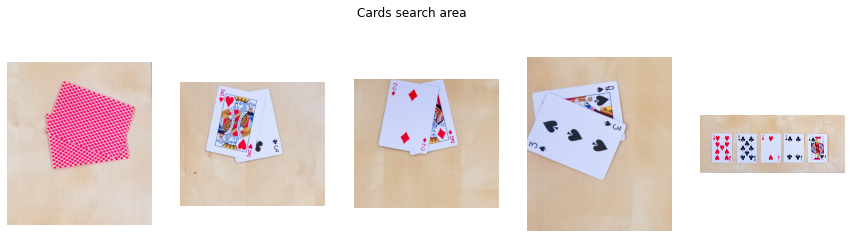

In [127]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize=(15,4))
for area, ax in zip(imgs, axes.flatten()):
    ax.imshow(area, cmap = 'gray')
    ax.axis('off')
fig.suptitle('Cards search area')
plt.show()

Use histograms to threshold green channel in procedure

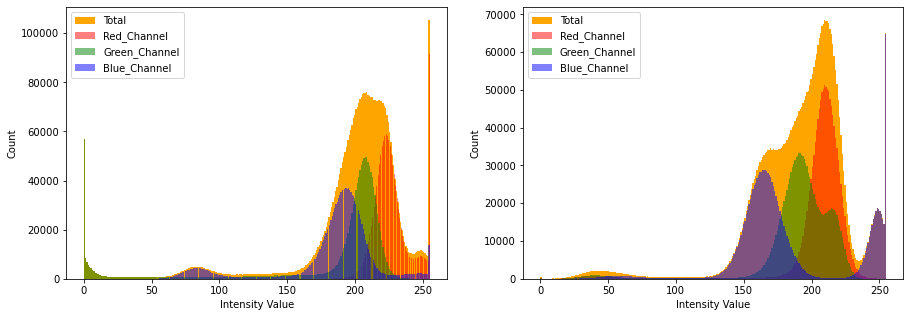

In [128]:
sample = [imgs[0], imgs[3]]
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
for ax, img in zip(axes, sample):
    ax.hist(img.ravel(), bins = 256, color = 'orange', )
    ax.hist(img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    ax.hist(img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
    ax.hist(img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
    ax.set_xlabel('Intensity Value')
    ax.set_ylabel('Count')
    ax.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

## Create card isolation procedure

In [129]:
def isolate_card_feat(img):
    # threshold green channel for a better grayscale contrast
    x = np.copy(img)
    cond = x[:,:,1] < 222
    x[cond] = 0
    
    # create the grayscale
    grayscale = skimage.color.rgb2gray(x)
    
    # get to mask
    k = cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
    x = skimage.morphology.binary_opening(grayscale, k)#, footprint=None, out=None)
    k = cv.getStructuringElement(cv.MORPH_CROSS,(6,6))
    x = skimage.morphology.binary_closing(x, k)#, footprint=None, out=None)
    
    mask = np.zeros((x.shape[0], x.shape[1]))
    [ct] = one_contour_by_img([x])
    mask[ct[:,1], ct[:,0]] = 255
    mask = nd.binary_fill_holes(mask)
    
    # clean the grayscale using the mask
    clean = grayscale * mask
    clean[mask==0] = 255
    # binarize the clean
    otsu = filters.threshold_otsu(clean)
    clean = (clean > otsu).astype(int)
    k = cv.getStructuringElement(cv.MORPH_CROSS,(1,1))
    clean = skimage.morphology.erosion(clean, k)#, footprint=None, out=None)
    
    
    
    return clean

In [130]:
mod_areas = [isolate_card_feat(img) for img in player_areas]

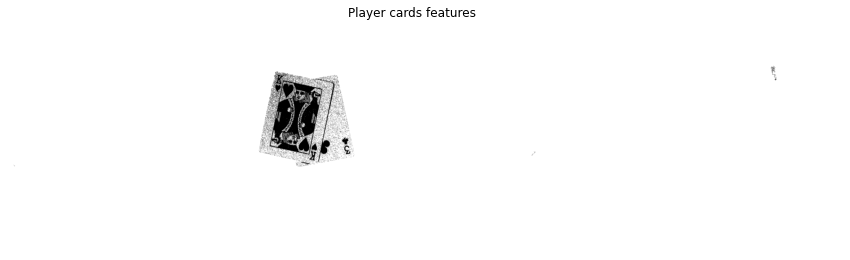

In [131]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(15,4))
for area, ax in zip(mod_areas, axes.flatten()):
    ax.imshow(area, cmap = 'gray')
    ax.axis('off')
fig.suptitle('Player cards features')
plt.show()

In [132]:
# def edge_detector(color_images, cts):
#     final_images = []
#     for image, ct in zip(color_images, cts):
#         x = skimage.color.rgb2gray(image)
#         # smooth for generalization and cleaning
#         #smoothed = filters.gaussian(grayscale, sigma = 1)
#         #x = skimage.filters.unsharp_mask(x, radius = 5)
#         # edge detector
#         x = filters.sobel(x)
        
#         otsu = filters.threshold_otsu(x)
#         x = x > otsu
#         plt.imshow(x, cmap='gray')
#         plt.show()
#         final_images.append(x)
#     return final_images

# def ALL_contours_by_img(img_list):
#     """ 
#     Extracts all contours for each image
#     return: list(  list(contour_1_img_1, ..., contour_m_img_1)  ,  ...,  list(contour_1_img_n, ..., contour_m_img_n)  )
#     """
#     cont_img = []
    
#     #Contours of images
#     for img in img_list:
#         # Compute all contours in image
#         contours, hierarchy = cv.findContours(img.astype(np.uint8) ,cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
        
#         # Case 1: 1 contour detected in image
#         if len(contours) == 1:
#             contour = contours[0][:,0]
#             contour = [contour]
#             # append 1 contour in a list
#             cont_img.append(contour)
            
            
#         # Case 2: more than 1 contour detected
#         else:
#             # append all contours in a list (necessary reshaping)
#             img_contours = [contours[i][:,0] for i in range(len(contours))]
#             cont_img.append(img_contours)
        
#     return cont_img

## try getting good contours with preprocess of player areas

In [133]:
""" REPRENDRE ICI """

edges = edge_detector(mod_areas)
contours = contours_by_img(edges)
#filt_contours = filter_contours_by_size(contours, 69, 310) #value taken from setup_data notebook
filt_contours = filter_contours_by_size(contours, 39, 410)

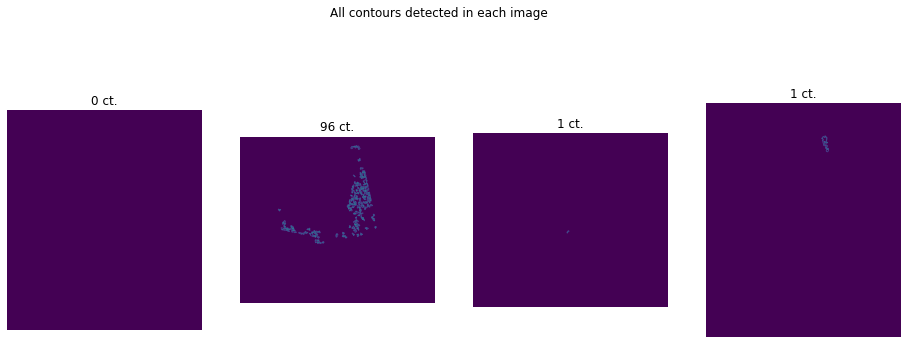

In [134]:
fig, axes = plt.subplots(ncols = 4, figsize=(16,15))
for ax, contours, image in zip(axes.flatten(), filt_contours, player_areas):
    im = np.zeros((image.shape[0], image.shape[1]))
    for contour in contours:
        im[contour[:,1], contour[:,0]] = 255
    ax.imshow(im)
    ax.set_title(f'{len(contours)} ct.')
    ax.axis('off')
fig.suptitle('All contours detected in each image', y = 0.7)
plt.show()

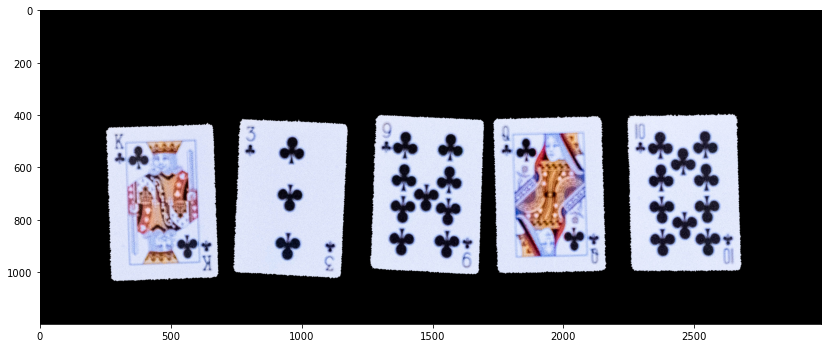

In [390]:
def isolate_common_cards(img):
    x = np.copy(img)
    cond = x[:,:,1] < 222
    x[cond] = 0
    x = skimage.color.rgb2gray(x)
    k = cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
    x = skimage.morphology.binary_opening(x, k)#, footprint=None, out=None)
    k = cv.getStructuringElement(cv.MORPH_CROSS,(6,6))
    x = skimage.morphology.binary_closing(x, k)#, footprint=None, out=None)
    im = np.zeros((x.shape[0], x.shape[1]))
    
    [cts] = contours_by_img([x])
    lengths = [len(ct) for ct in cts]
    idx = np.argsort(lengths)
    cts_of_cards = ([cts[i] for i in idx])[-5:]
    for ct in cts_of_cards:
        im[ct[:,1], ct[:,0]] = 255
    im = nd.binary_fill_holes(im)
    #plt.imshow(im, cmap = 'gray')
    #plt.show()
    return im
    #plt.imshow(x, cmap = 'gray')
mask = isolate_common_cards(common_areas)[..., np.newaxis]
plt.figure(figsize=(14,6))
plt.imshow(mask*common_areas)
plt.show()

## prediction stuff

In [78]:
n = 10
cards_comp_ct = [complex_contours(card_cont) for card_cont in filt_contours]
test_descr = [n_FT_descr(comp_ct, n) for comp_ct in cards_comp_ct]

In [79]:
test_3D_descr = []
for card_descr in test_descr:
    if len(card_descr)!=0:
        descr_1 = card_descr[:,1]
        descr_2 = card_descr[:,2]
        descr_3 = card_descr[:,3]
        descr_4 = card_descr[:,4]
        descr_5 = card_descr[:,5]
        descr_6 = card_descr[:,6]
        descr_7 = card_descr[:,7]
        descr_8 = card_descr[:,8]
        descr_9 = card_descr[:,9]
        card_contours_descr = np.vstack([descr_1,descr_2,descr_3,
                                         descr_4,descr_5,descr_6,
                                        descr_7,descr_8,descr_9]).T
    else: card_contours_descr = np.zeros(9)
    test_3D_descr.append(card_contours_descr)

In [80]:
GT_descr = np.load('GT_descr.npy', allow_pickle = True)

In [81]:
def player_pred(descr, contours, GT_descr, player_id, number_keys, symbol_keys):
    # separate number and symbols descr
    NB_descr = GT_descr[:-4]
    SYM_descr = GT_descr[-4:]
    
    # set default as returned card case
    cards = ['0', '0']
    
    if not (descr == np.zeros(9)).all() and len(contours) >= 6:
        """Preselect contours associated numbers"""
        # for each contour, compute distance of every number descr to it
        ct_to_nb_dist = []
        nb_cont = []
        nb_keys = []
        # iterate over each contour
        for ct_descr, ct in zip(descr, contours):
            diff = ct_descr - NB_descr
            dist = np.linalg.norm(diff.astype(float), axis = 1)
            # pick most likely number fo contour and record
            idx = np.argmin(dist)
            ct_to_nb_dist.append(dist[idx])
            nb_cont.append(ct)
            nb_keys.append(number_keys[idx])
        
        """ Preselect contours associated symbols """
        # for each contour, compute distance of every symbol descr to it
        ct_to_sym_dist = []
        sym_cont = []
        sym_keys = []
        # iterate over each contour
        for ct_descr, ct in zip(descr, contours):
            diff = ct_descr - SYM_descr
            dist = np.linalg.norm(diff.astype(float), axis = 1)
            # pick most likely symbol fo contour and record
            idx = np.argmin(dist)
            ct_to_sym_dist.append(dist[idx])
            sym_cont.append(ct)
            sym_keys.append(symbol_keys[idx])
        
        """ Define true symbols, EASIER TO ISOLATE than numbers (need 3) """
        # compute center of contours to approximate location
        ct_locs = np.array([np.mean(contour, axis = 0) for contour in contours])
        
        sorted_idx = np.argsort(ct_to_sym_dist)
        sym_cont = ([sym_cont[i] for i in sorted_idx])[:3]
        sym_keys = ([sym_keys[i] for i in sorted_idx])[:3]
        sym_locs = ([ct_locs[i] for i in sorted_idx])[:3]
        
        """ take min distance number-symbol pairs to find the 3 pairs of interest """
        candidate_pairs = []
        candidate_locations = []
        candidates_dist = []
        for sym_loc, sym_key in zip(sym_locs, sym_keys):
            # for each candidate symbol, compute distance to candidate number
            dist = np.linalg.norm(sym_loc-ct_locs, axis = 1)
                
            # sort distances with number keys and means accordingly
            idx = np.argsort(dist)
            sorted_dist = dist[idx]
            sorted_nb_key = [nb_keys[i] for i in idx] 
            sorted_nb_locs = ct_locs[idx] 
            
            # create minimal distance pair, record location for later and
            # make sure we dont create a pair of similar contours by taking [1]
            candidate_pairs.append(sorted_nb_key[1]+sym_key)
            candidate_locations.append((sorted_nb_locs[1] + sym_loc)/2)
            candidates_dist.append(sorted_dist[1])


        #print(candidate_pairs)
        #print(candidate_locations)
        #print(candidates_dist)
        
        # take 2 different pairs amond the 3
        if candidate_pairs[0] != candidate_pairs[1]:
            cards_ID = np.array([candidate_pairs[0], candidate_pairs[1]])
            locations = np.array([candidate_locations[0], candidate_locations[1]])
        else:
            cards_ID = np.array([candidate_pairs[0], candidate_pairs[2]])
            locations = np.array([candidate_locations[0], candidate_locations[2]])
        
        """ identify which card is where """ #using locations and player ID
        if player_id in [1,4]:
            up_idx = np.argmin(locations[:,1])
            down_idx = np.argmax(locations[:,1])
            up_card = cards_ID[up_idx]
            down_card = cards_ID[down_idx]
            cards = [down_card, up_card]
        
        if player_id in [2,3]:
            left_idx = np.argmin(locations[:,0])
            right_idx = np.argmax(locations[:,0])
            left_card = cards_ID[left_idx]
            right_card = cards_ID[right_idx]
            cards = [left_card, right_card]

    return cards


number_keys = np.array(['K', 'Q', 'J', '10', '9',
                        '8', '7', '6', '5', '4',
                                '3', '2', 'A'])
symbol_keys = np.array(['trèfle', 'pique', 'carreau', 'coeur'])


#player_pred(test_3D_descr[0], filt_contours[0], GT_descr, 4, number_keys, symbol_keys)

In [82]:
for i in range(4):
    cards = player_pred(test_3D_descr[i], filt_contours[i], GT_descr, 4-i, number_keys, symbol_keys)
    print(cards)

['Acoeur', '8carreau']
['8carreau', '8carreau']
['Apique', '8coeur']
['Acarreau', '8coeur']
